In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [3]:
location = 'nw2'
turbine = 'd01'
mode = 'SS2'

In [4]:
# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.getcwd()))
data_folder = os.path.join(package_folder, 'data')

In [5]:
from src.data.utils import get_input_data
data = get_input_data(data_folder, location, turbine)
data['turbine_data'].columns

Index(['location', 'mean_NW2_D01_rpm', 'mean_NW2_D01_yaw', 'std_NW2_D01_pitch',
       'mean_NW2_D01_pitch', 'mean_NW2_D01_power', 'std_NW2_D01_towerxacc',
       'std_NW2_D01_toweryacc', 'std_NW2_D01_windspeed',
       'mean_NW2_D01_towerxacc', 'mean_NW2_D01_toweryacc',
       'mean_NW2_D01_windspeed', 'mean_NW2_D01_winddirection',
       'mpe_NW2_D01_FA', 'mpe_NW2_D01_SS', 'mpe_NW2_D01_FA1',
       'mpe_NW2_D01_SS1', 'max_NW2_D01_NAC_ACC_Z', 'min_NW2_D01_NAC_ACC_Z',
       'rms_NW2_D01_NAC_ACC_Z', 'std_NW2_D01_NAC_ACC_Z',
       'max_NW2_D01_NAC_ACC_FA', 'max_NW2_D01_NAC_ACC_SS',
       'mean_NW2_D01_NAC_ACC_Z', 'min_NW2_D01_NAC_ACC_FA',
       'min_NW2_D01_NAC_ACC_SS', 'rms_NW2_D01_NAC_ACC_FA',
       'rms_NW2_D01_NAC_ACC_SS', 'std_NW2_D01_NAC_ACC_FA',
       'std_NW2_D01_NAC_ACC_SS', 'mean_NW2_D01_NAC_ACC_FA',
       'mean_NW2_D01_NAC_ACC_SS', 'rms1p_NW2_D01_NAC_ACC_Z',
       'rms1p_NW2_D01_NAC_ACC_FA', 'rms1p_NW2_D01_NAC_ACC_SS',
       'mpe_NW2_D01_Z'],
      dtype='object')

In [517]:
from src.data.make_dataset import create_input_target_dataset
X, y = create_input_target_dataset(data_folder, location, turbine, mode)

rpm_split = 6.5

X_lowrpm = X.loc[X.filter(regex = 'rpm')[X.filter(regex = 'rpm') < rpm_split].dropna().index]
y_lowrpm = y.loc[X_lowrpm.index]

# Split the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_lowrpm, y_lowrpm, test_size=0.1, shuffle=False)
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=123)

In [518]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

regr_model = CatBoostRegressor(iterations=2000, depth=3, random_seed=0, posterior_sampling=True, loss_function='RMSEWithUncertainty', verbose=False, learning_rate=0.01)
regr_model.fit(X_train, y_train)

In [519]:
low_rpm_preds_ = regr_model.virtual_ensembles_predict(X_lowrpm, prediction_type='TotalUncertainty', virtual_ensembles_count=20, ntree_end=100)
low_rpm_preds_df = pd.DataFrame(low_rpm_preds_, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X_lowrpm.index)

low_rpm_preds = low_rpm_preds_[:,0] # mean values predicted by a virtual ensemble
low_rpm_knowledge_uncertainty = low_rpm_preds_[:,1] # knowledge uncertainty predicted by a virtual ensemble
low_rpm_data_uncertainty = low_rpm_preds_[:,2] # average estimated data uncertainty


In [520]:
preds_ = regr_model.virtual_ensembles_predict(X, prediction_type='TotalUncertainty', virtual_ensembles_count=20, ntree_end=100)
preds_df = pd.DataFrame(preds_, columns=['prediction', 'knowledge uncertainty', 'data uncertainty'], index=X.index)

preds = preds_[:,0] # mean values predicted by a virtual ensemble
knowledge_uncertainty = preds_[:,1] # knowledge uncertainty predicted by a virtual ensemble
data_uncertainty = preds_[:,2] # average estimated data uncertainty

In [550]:
full_predicitions_ = pd.DataFrame(regr_model.predict(X), index=X.index)

full_predicitions_uncertainty = full_predicitions_.iloc[:,1]
full_predicitions = full_predicitions_.iloc[:,0]

In [551]:
data_uncertainty_lim = 0.0006
low_data_uncertainty_predictipons = preds_df[preds_df['data uncertainty'] < data_uncertainty_lim]

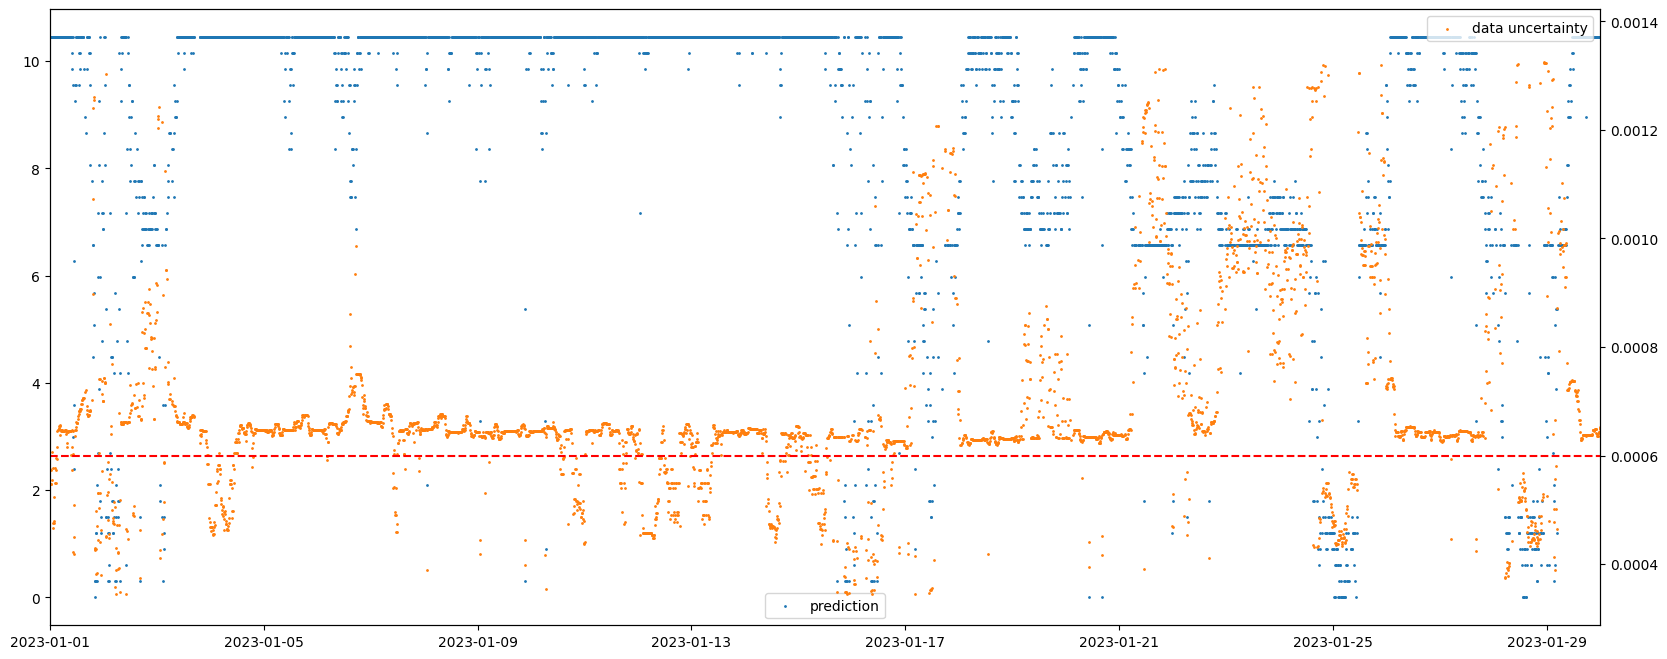

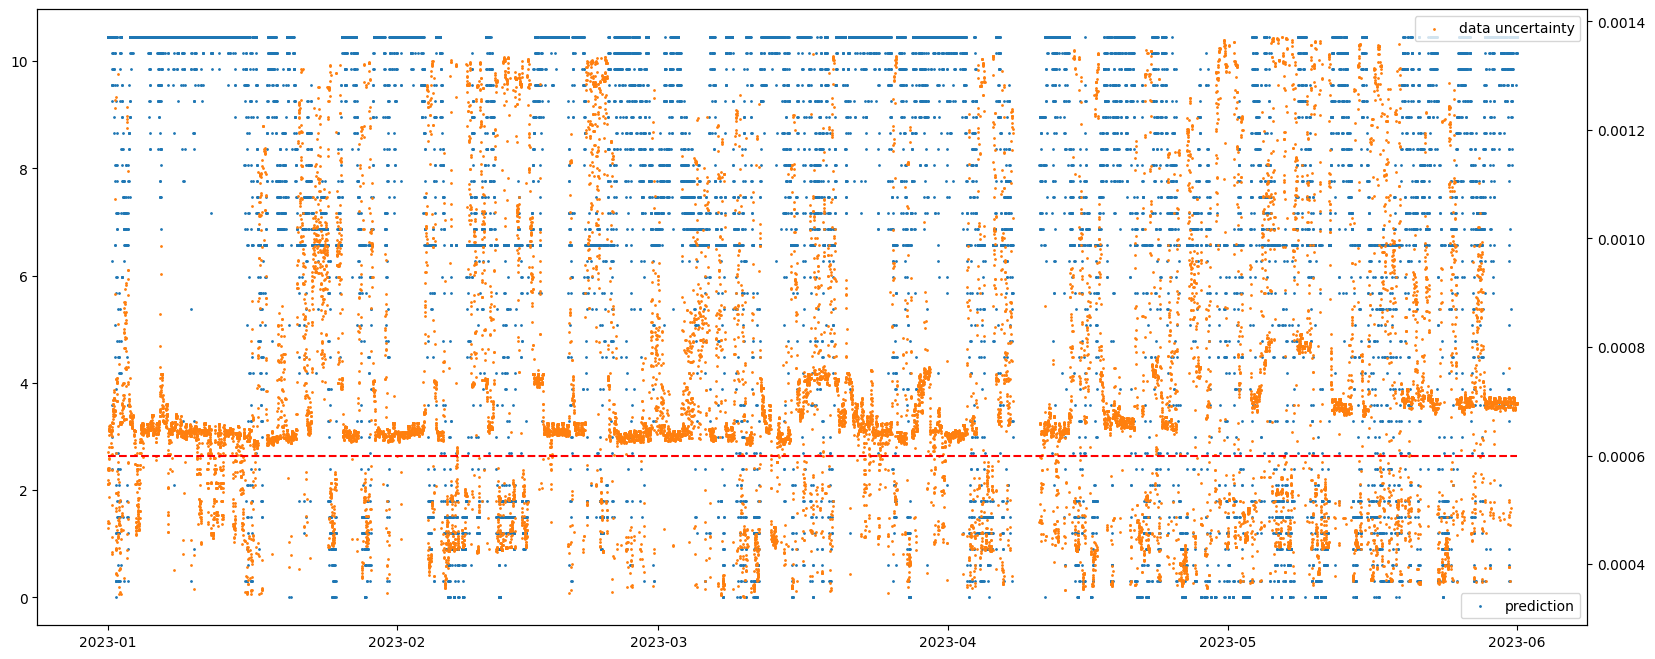

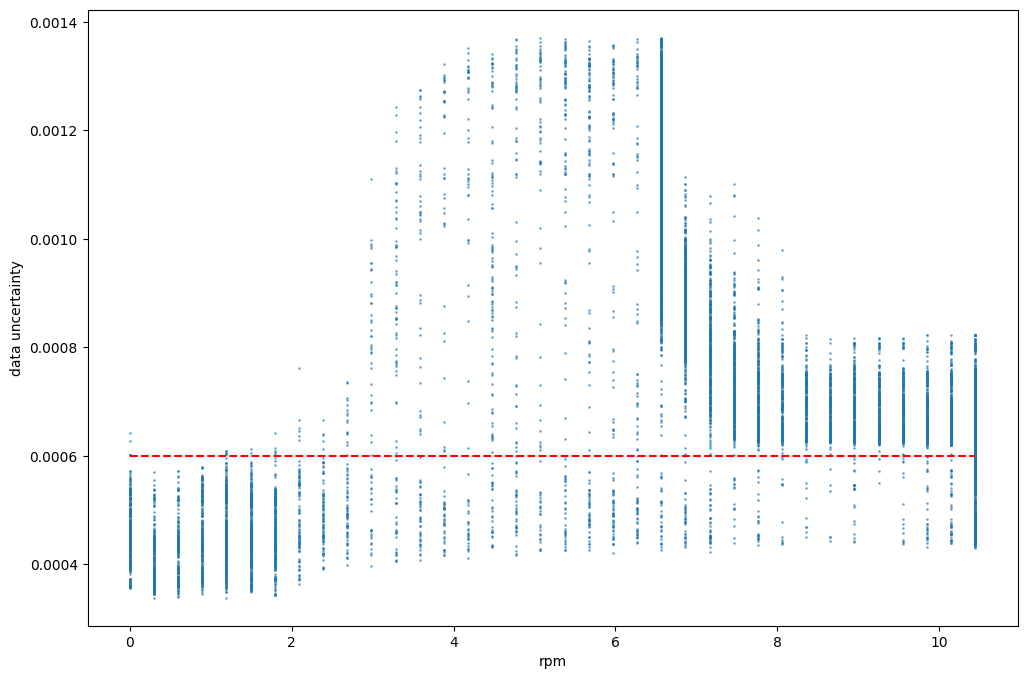

In [552]:
plt.figure(figsize=(20,8))

# Plot the first scatter plot
plt.scatter(X.index, X.filter(regex='rpm'), label='prediction', s=1)
plt.legend()
# Create the twin axis
ax2 = plt.twinx()

# Plot the second scatter plot on the twin axis
#ax2.scatter(preds_df.index, preds_df['knowledge uncertainty'], label='knowledge uncertainty')
ax2.scatter(preds_df.index, preds_df['data uncertainty'], label='data uncertainty', s=1, color='tab:orange')
plt.xlim(datetime.datetime(2023, 1, 1), datetime.datetime(2023, 1, 30))
plt.hlines(data_uncertainty_lim, datetime.datetime(2023, 1, 1), datetime.datetime(2023, 1, 30), color='red', linestyle='--')
# Show the legend
plt.legend(loc='upper right')

# Show the plot
plt.show()
plt.close()

plt.figure(figsize=(20,8))

# Plot the first scatter plot
plt.scatter(X.index, X.filter(regex='rpm'), label='prediction', s=1)
plt.legend()
# Create the twin axis
ax2 = plt.twinx()

# Plot the second scatter plot on the twin axis
#ax2.scatter(preds_df.index, preds_df['knowledge uncertainty'], label='knowledge uncertainty')
ax2.scatter(preds_df.index, preds_df['data uncertainty'], label='data uncertainty', s=1, color='tab:orange')
plt.hlines(data_uncertainty_lim, preds_df.index[0] ,preds_df.index[-1], color='red', linestyle='--')
# Show the legend
plt.legend(loc='upper right')

# Show the plot
plt.show()
plt.close()


plt.figure(figsize=(12,8))
plt.scatter(X.filter(regex='rpm'), preds_df['data uncertainty'], s=1, alpha=0.5)
plt.ylabel('data uncertainty')
plt.xlabel('rpm')
plt.hlines(data_uncertainty_lim, 0, X.filter(regex='rpm').max(), color='red', linestyle='--')
plt.show()
plt.close()

In [553]:
rpms

array([ 0.   ,  0.298,  0.597,  0.895,  1.194,  1.492,  1.79 ,  2.089,
        2.387,  2.686,  2.984,  3.283,  3.581,  3.879,  4.178,  4.476,
        4.775,  5.073,  5.371,  5.67 ,  5.968,  6.267,  6.565,  6.864,
        7.162,  7.46 ,  7.759,  8.057,  8.356,  8.654,  8.952,  9.251,
        9.549,  9.848, 10.146, 10.445])

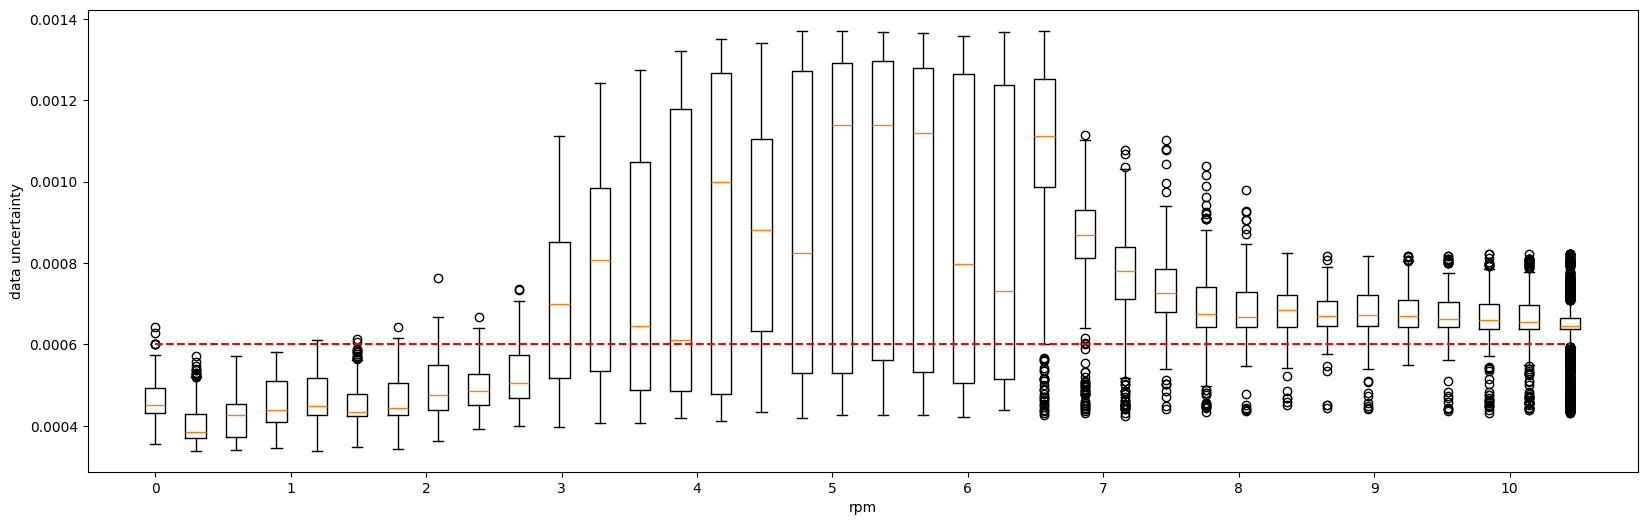

In [554]:
boxplot_data = pd.DataFrame({'data uncertainty':preds_df['data uncertainty'].values, 'rpm':X.filter(regex='rpm').values[:,0]})
rpms = np.unique(boxplot_data['rpm'])
plt.figure(figsize=(20,6))
for rpm in rpms:
    # Make a boxplot at the x value of the rpm
    plt.boxplot(boxplot_data[boxplot_data['rpm']==rpm]['data uncertainty'], positions=[rpm])
plt.ylabel('data uncertainty')
plt.xlabel('rpm')
plt.hlines(data_uncertainty_lim, 0, X.filter(regex='rpm').max(), color='red', linestyle='--')
# Only show one x tick every 5 ticks
plt.xticks(np.arange(11), np.arange(11))
plt.show()
plt.close()

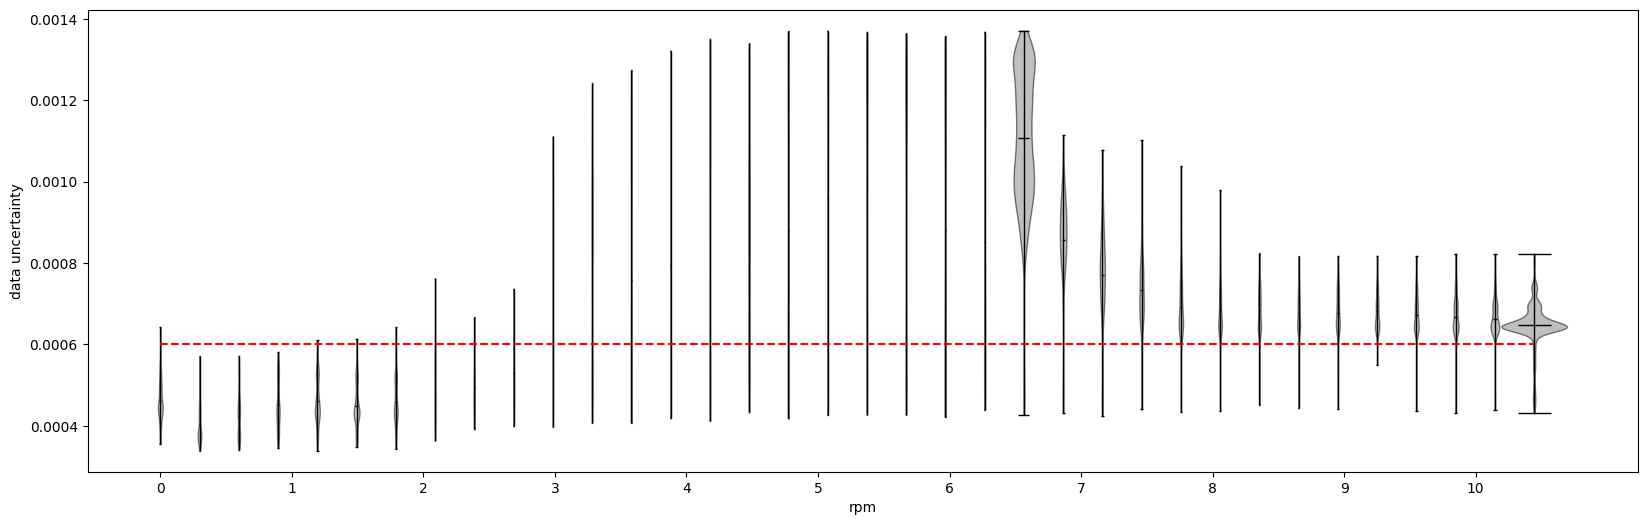

In [555]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming boxplot_data and data_uncertainty_lim are already defined

# Count and normalize samples per RPM
sample_counts = boxplot_data.groupby('rpm').size()
max_samples = sample_counts.max()
normalized_widths = sample_counts / max_samples * 0.5  # Adjust 0.5 to control max width

plt.figure(figsize=(20,6))
for rpm in rpms:
    # Set the width of the violin plot based on sample count
    width = normalized_widths[rpm]
    
    # Generate the violin plot with dynamic width
    violin = plt.violinplot(boxplot_data[boxplot_data['rpm'] == rpm]['data uncertainty'], positions=[rpm], showmeans=True, widths=width)
    
    # Customize the appearance
    for pc in violin["bodies"]:
        pc.set_facecolor("grey")
        pc.set_edgecolor("black")
        pc.set_alpha(0.5)

    for partname in ('cbars', 'cmins', 'cmaxes', 'cmeans'):
        vp = violin[partname]
        vp.set_edgecolor("k")
        vp.set_linewidth(1)

plt.ylabel('data uncertainty')
plt.xlabel('rpm')
plt.hlines(data_uncertainty_lim, 0, X.filter(regex='rpm').max(), color='red', linestyle='--')
plt.xticks(np.arange(11), np.arange(11))

plt.show()
plt.close()


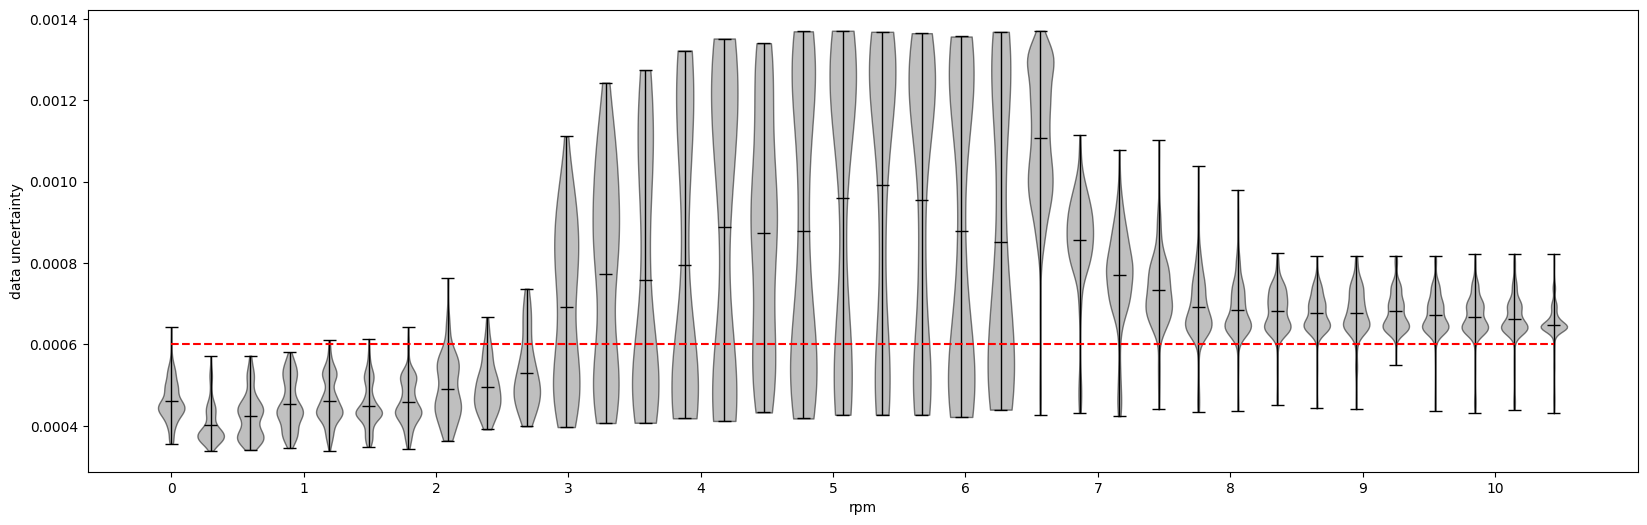

In [556]:
boxplot_data = pd.DataFrame({'data uncertainty':preds_df['data uncertainty'].values, 'rpm':X.filter(regex='rpm').values[:,0]})
rpms = np.unique(boxplot_data['rpm'])
plt.figure(figsize=(20,6))
for rpm in rpms:
    # Make a violinplot at the x value of the rpm width=0.5 # in a black color with mean in red
    violin = plt.violinplot(boxplot_data[boxplot_data['rpm']==rpm]['data uncertainty'], positions=[rpm], showmeans=True, widths=0.2)

    #plt.violinplot(boxplot_data[boxplot_data['rpm']==rpm]['data uncertainty'], positions=[rpm], showmeans=True, widths=0.2, c='k')
    # Make a boxplot at the x value of the rpm
    #plt.boxplot(boxplot_data[boxplot_data['rpm']==rpm]['data uncertainty'], positions=[rpm])
    for pc in violin["bodies"]:
        pc.set_facecolor("grey")
        pc.set_edgecolor("black")
        pc.set_alpha(0.5)

    for partname in ('cbars', 'cmins', 'cmaxes'):
        vp = violin[partname]
        vp.set_edgecolor("k")
        vp.set_linewidth(1)

    for partname in (['cmeans']):
        vp = violin[partname]
        vp.set_edgecolor("k")
        vp.set_linewidth(1)  



plt.ylabel('data uncertainty')
plt.xlabel('rpm')
plt.hlines(data_uncertainty_lim, 0, X.filter(regex='rpm').max(), color='red', linestyle='--')
# Only show one x tick every 5 ticks
plt.xticks(np.arange(11), np.arange(11))
plt.show()
plt.close()

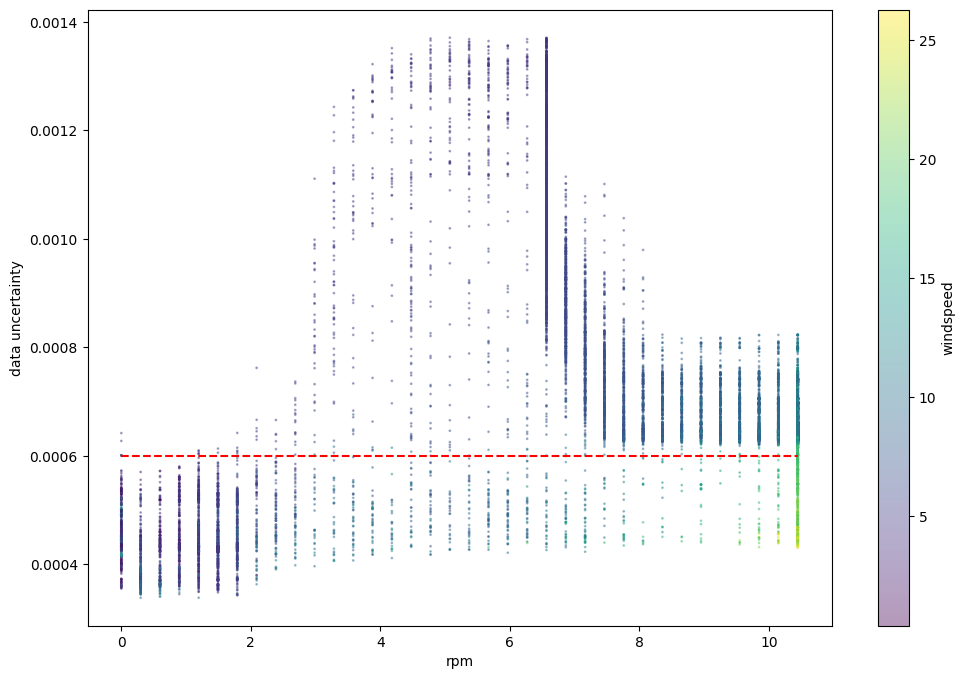

In [557]:
plt.figure(figsize=(12,8))
plt.scatter(X.filter(regex='rpm'), preds_df['data uncertainty'], c=X.filter(regex='windspeed').values, cmap='viridis' ,s=1, alpha=0.4)
cbar = plt.colorbar()
# increase alpha of the colorbar to 1
cbar.set_alpha(1)
cbar.set_label('windspeed')
plt.ylabel('data uncertainty')
plt.xlabel('rpm')
plt.hlines(data_uncertainty_lim, 0, X.filter(regex='rpm').max(), color='red', linestyle='--')
plt.show()
plt.close()

In [558]:
def transform_uncertainty(uncertainty: pd.Series, max_value: float):
    transformed_uncertainty = uncertainty.copy()
    transformed_uncertainty[transformed_uncertainty > max_value] = max_value
    transformed_uncertainty = transformed_uncertainty / max_value
    return transformed_uncertainty

transformed_data_uncertainty = transform_uncertainty(data_uncertainty, data_uncertainty_lim)

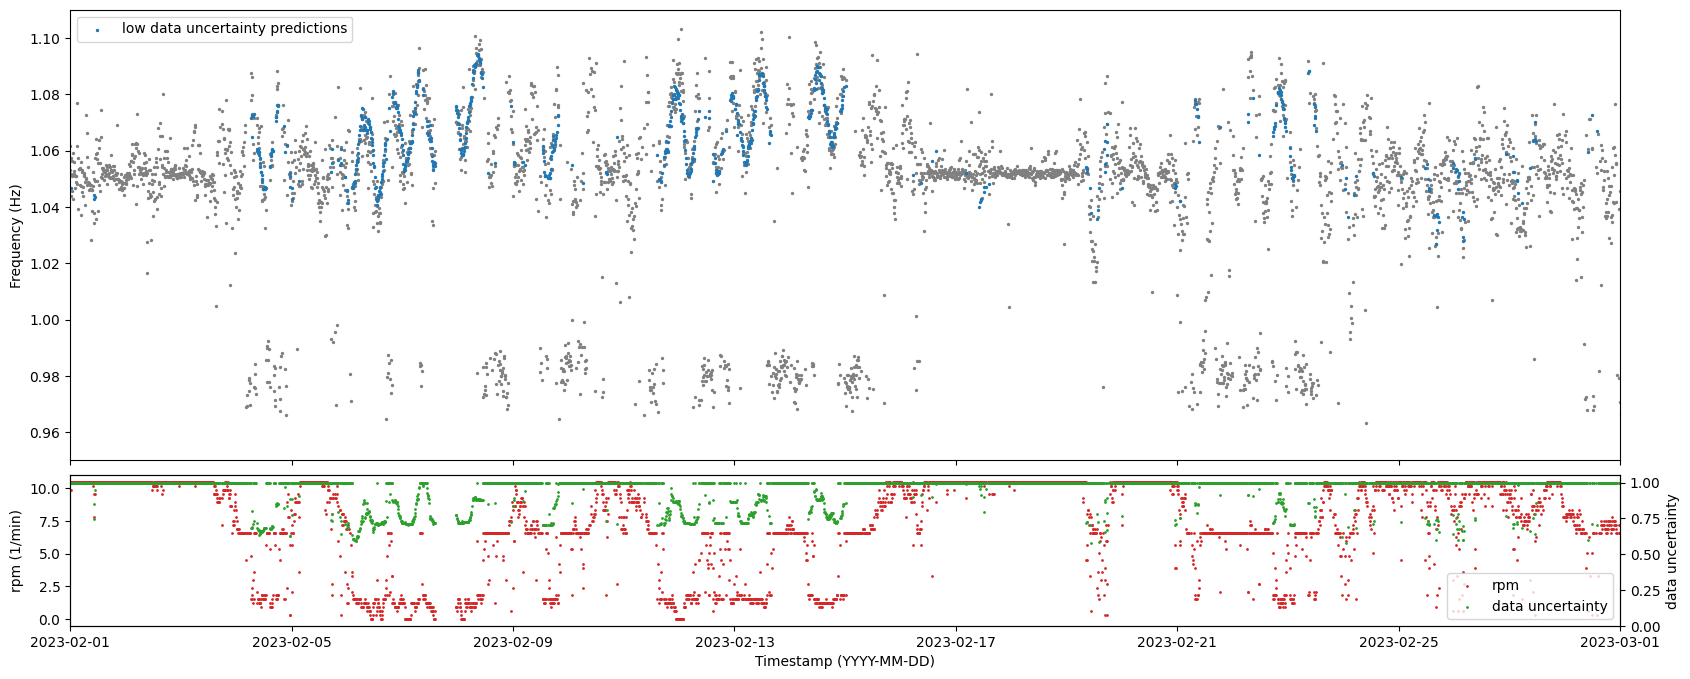

In [579]:
import matplotlib.pyplot as plt
import datetime

# Create two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot on the first subplot
ax1.scatter(y.index, y, s=2, color='grey')
#ax1.scatter(y_lowrpm.index, low_rpm_preds_df['prediction'], s=10, color='tab:blue', label='low rpm predictions')
#ax1.scatter(low_data_uncertainty_predictipons.index, low_data_uncertainty_predictipons['prediction'], s=2, color='tab:orange', label='low data uncertainty predictions')
ax1.scatter(low_data_uncertainty_predictipons.index, full_predicitions.loc[low_data_uncertainty_predictipons.index], s=2, color='tab:blue', label='low data uncertainty predictions')
#ax1.scatter(smart_tracked_modes.index, smart_tracked_modes, s=1, color='k', label='smart tracked modes')

ax1.set_ylim(0.95, 1.11)
ax1.legend(loc='upper left')
ax1.set_ylabel('Frequency (Hz)')

# Plot on the second subplot
ax2.scatter(X.index, X.filter(regex='rpm'), label='rpm', s=1, color='tab:red')
ax2.set_ylabel('rpm (1/min)')
ax2.set_xlabel('Timestamp (YYYY-MM-DD)')

ax3 = ax2.twinx()
ax3.scatter(X.index,transformed_data_uncertainty, label='data uncertainty', s=1, color='tab:green')
ax3.set_ylabel('data uncertainty')
ax3.set_ylim(0,1.05)

# Collect handles and labels for ax2 and ax3
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()

# Combine handles and labels
combined_handles = handles2 + handles3
combined_labels = labels2 + labels3

# Create a single combined legend
plt.legend(combined_handles, combined_labels, loc='lower right')

# Set shared x-axis properties
plt.xlim(datetime.datetime(2023, 2, 1), datetime.datetime(2023, 3, 1))
plt.subplots_adjust(hspace=0.05)  # Adjust this value as needed


plt.show()
plt.close()


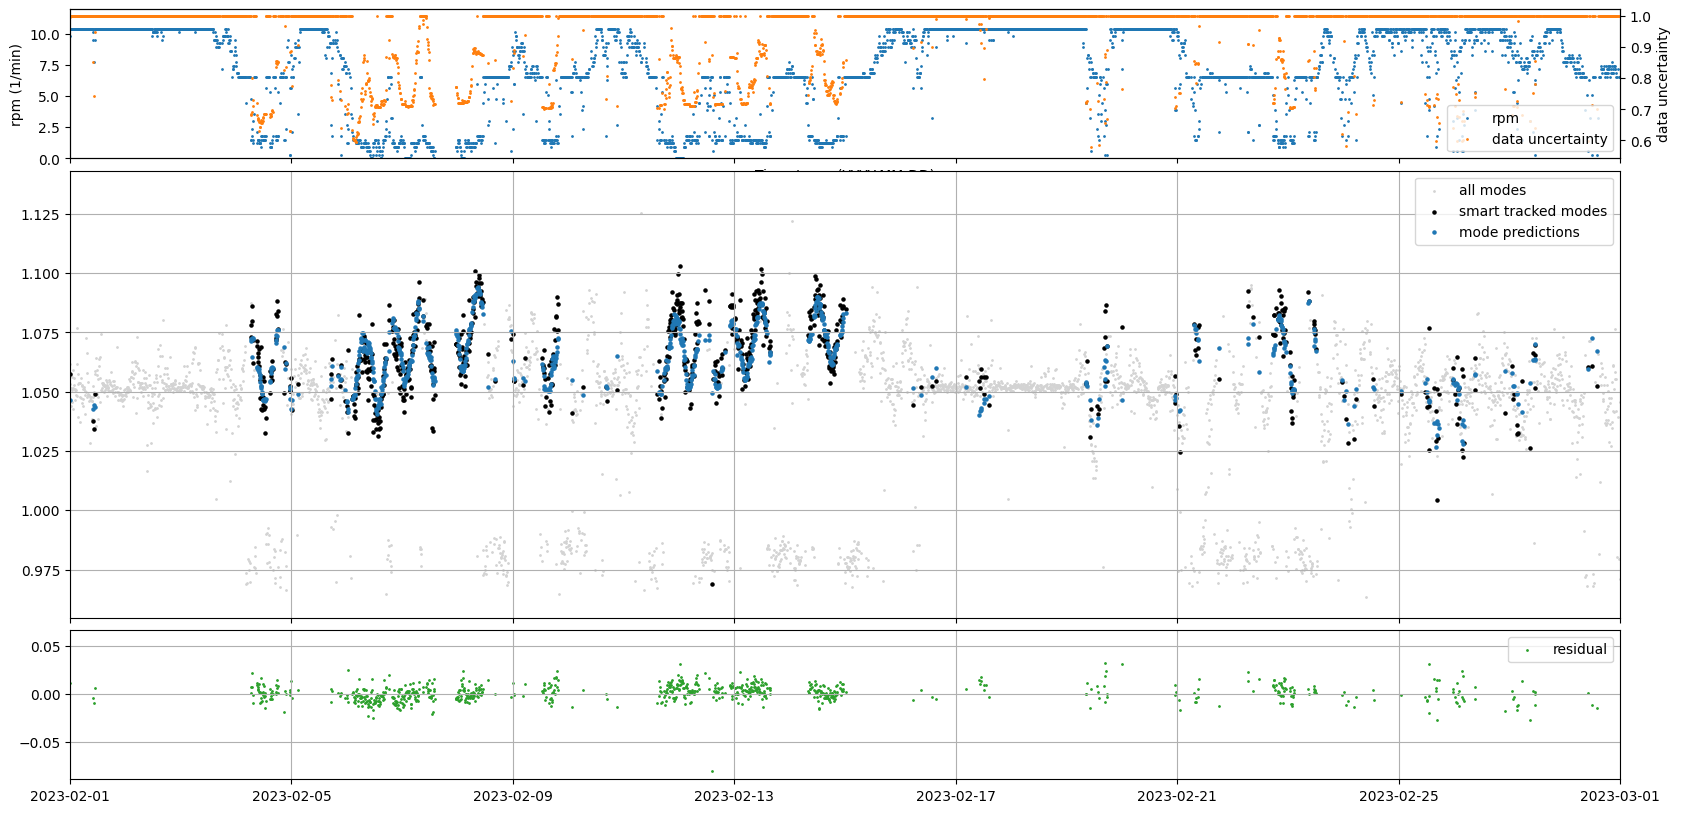

In [584]:
def transform_uncertainty(uncertainty: pd.Series, max_value: float):
    transformed_uncertainty = uncertainty.copy()
    transformed_uncertainty[transformed_uncertainty > max_value] = max_value
    transformed_uncertainty = transformed_uncertainty / max_value
    return transformed_uncertainty

def smart_track(tracked_modes: pd.Series, predictions: pd.Series, uncertainty: pd.Series, uncertainty_limit: float):
    smart_tracked = tracked_modes.loc[uncertainty<uncertainty_limit].copy()
    return smart_tracked

transformed_data_uncertainty = transform_uncertainty(data_uncertainty, data_uncertainty_lim)
smart_tracked_modes = smart_track(y, preds, data_uncertainty, data_uncertainty_lim)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 10), sharex=True, gridspec_kw={'height_ratios': [1, 3, 1]})

# Plot on the second subplot
ax1.scatter(X.index, X.filter(regex='rpm'), label='rpm', s=1, color='tab:blue')
ax1.set_ylabel('rpm (1/min)')
ax1.set_xlabel('Timestamp (YYYY-MM-DD)')
ax1.set_ylim(0,12)

ax4 = ax1.twinx()
ax4.scatter(X.index,transformed_data_uncertainty, label='data uncertainty', s=1, color='tab:orange')
ax4.set_ylabel('data uncertainty')

# Collect handles and labels for ax2 and ax3
handles2, labels2 = ax1.get_legend_handles_labels()
handles3, labels3 = ax4.get_legend_handles_labels()

# Combine handles and labels
combined_handles = handles2 + handles3
combined_labels = labels2 + labels3

# Create a single combined legend
plt.legend(combined_handles, combined_labels, loc='lower right')

ax2.scatter(y.index, y, s=1, color='lightgrey', label = 'all modes')
ax2.scatter(smart_tracked_modes.index, smart_tracked_modes, s=5, color='k', label='smart tracked modes')
ax2.scatter(smart_tracked_modes.index, full_predicitions.loc[smart_tracked_modes.index], s=5, color='tab:blue', label='mode predictions')
ax2.legend()
ax2.grid()

ax3.scatter(smart_tracked_modes.index, y.loc[smart_tracked_modes.index] - full_predicitions.loc[smart_tracked_modes.index], s=1, color='tab:green', label='residual')
ax3.legend()
ax3.grid()

plt.xlim(datetime.datetime(2023, 2, 1), datetime.datetime(2023, 3, 1))
plt.subplots_adjust(hspace=0.05)  # Adjust this value as needed

plt.show()
plt.close()


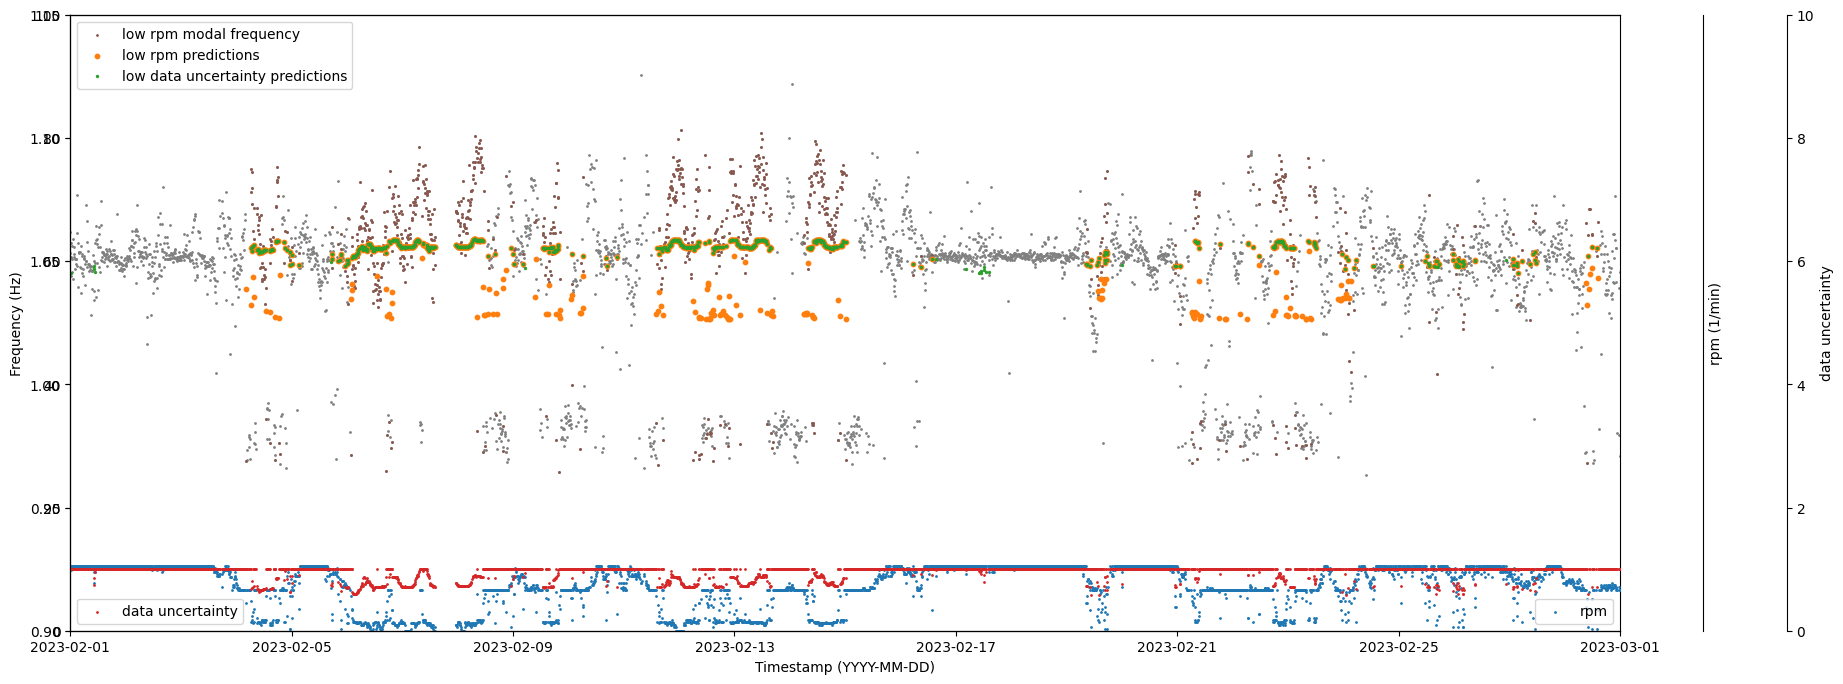

In [560]:
import matplotlib.pyplot as plt
import datetime
plt.figure(figsize=(20,8))
plt.scatter(y.index, y, s=1, color='grey')
#plt.scatter(preds_df.index, preds_df['prediction'], s=1, label='all predcitions', color='tab:blue')

plt.scatter(y_lowrpm.index, y_lowrpm, s=1, color='tab:brown', label='low rpm modal frequency')
plt.scatter(y_lowrpm.index, low_rpm_preds_df['prediction'], s=10, color='tab:orange', label='low rpm predictions')
plt.scatter(low_data_uncertainty_predictipons.index, low_data_uncertainty_predictipons['prediction'], s=2, color='tab:green', label='low data uncertainty predictions')
plt.ylim(0.9, 1.15)
plt.legend(loc='upper left')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Timestamp (YYYY-MM-DD)')

ax2 = plt.twinx()
ax2.scatter(X.index, X.filter(regex='rpm'), label='rpm', s=1, color='tab:blue')
ax2.set_ylabel('rpm (1/min)')
ax2.spines['right'].set_position(('outward', 60))  # Adjust the position of the right spine
ax2.legend(loc='lower right')
ax2.set_ylim(0,100)

ax3 = plt.twinx()
ax3.spines['right'].set_position(('outward', 120))  # Adjust the position of the right spine further
ax3.scatter(X.index,transformed_data_uncertainty, label='data uncertainty', s=1, color='tab:red')
ax3.set_ylabel('data uncertainty')
ax3.set_ylim(0,10)

plt.xlim(datetime.datetime(2023, 2, 1), datetime.datetime(2023, 3, 1))
plt.legend(loc='lower left')

plt.show()
plt.close()

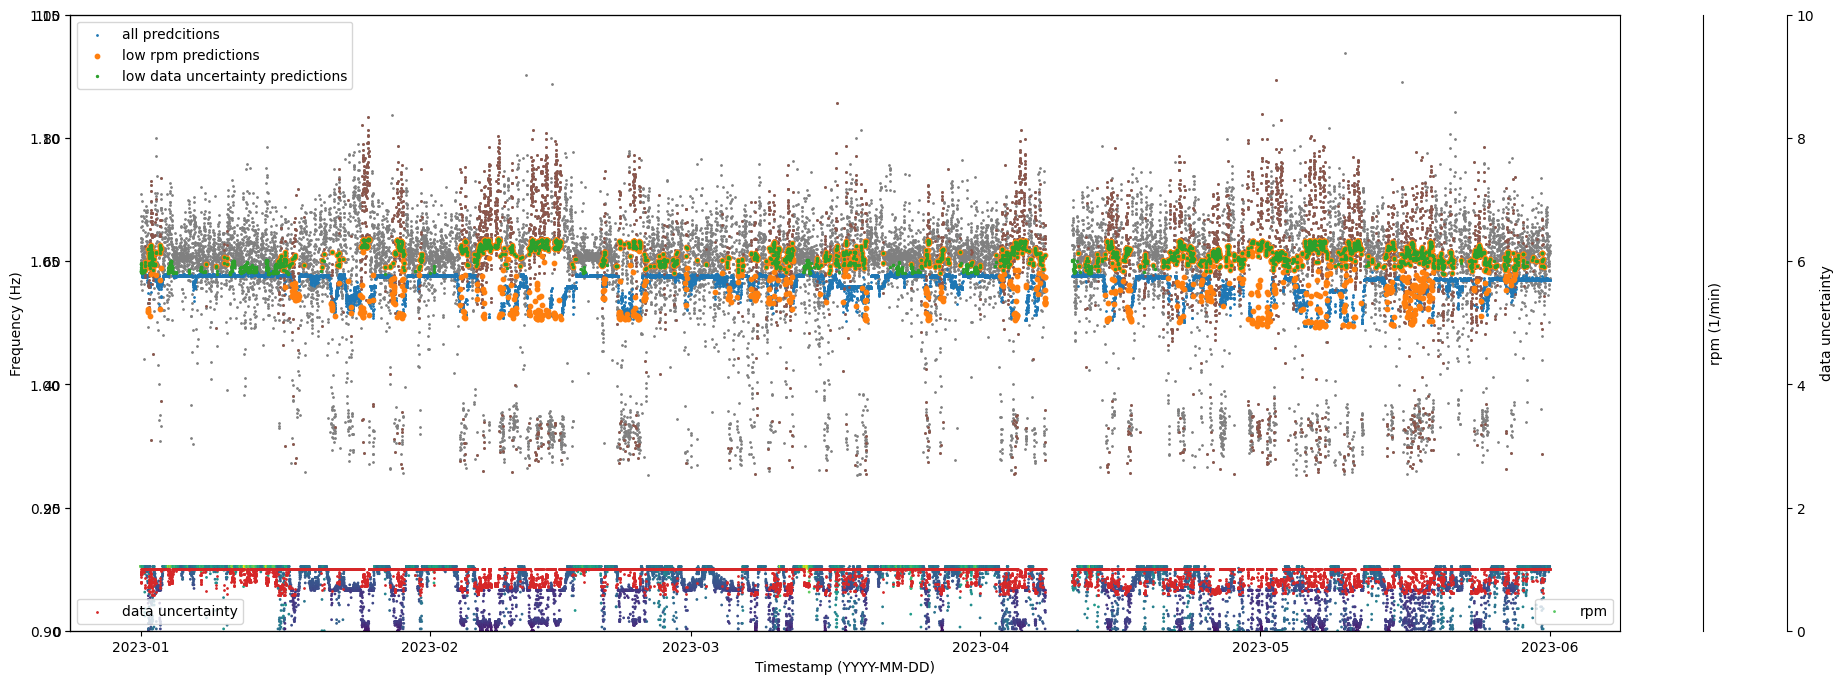

In [561]:
    import matplotlib.pyplot as plt
import datetime
plt.figure(figsize=(20,8))
plt.scatter(y.index, y, s=1, color='grey')
plt.scatter(preds_df.index, preds_df['prediction'], s=1, label='all predcitions', color='tab:blue')

plt.scatter(y_lowrpm.index, y_lowrpm, s=1, color='tab:brown')
plt.scatter(y_lowrpm.index, low_rpm_preds_df['prediction'], s=10, color='tab:orange', label='low rpm predictions')
plt.scatter(low_data_uncertainty_predictipons.index, low_data_uncertainty_predictipons['prediction'], s=2, color='tab:green', label='low data uncertainty predictions')
plt.ylim(0.9, 1.15)
plt.legend(loc='upper left')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Timestamp (YYYY-MM-DD)')

ax2 = plt.twinx()
ax2.scatter(X.index, X.filter(regex='rpm'), label='rpm', s=1, c=X.filter(regex='windspeed').values, cmap='viridis')
ax2.set_ylabel('rpm (1/min)')
ax2.spines['right'].set_position(('outward', 60))  # Adjust the position of the right spine
ax2.legend(loc='lower right')
ax2.set_ylim(0,100)

ax3 = plt.twinx()
ax3.spines['right'].set_position(('outward', 120))  # Adjust the position of the right spine further
ax3.scatter(X.index,transformed_data_uncertainty, label='data uncertainty', s=1, color='tab:red')
ax3.set_ylabel('data uncertainty')
ax3.set_ylim(0,10)

plt.legend(loc='lower left')

plt.show()
plt.close()

[18.1931357   7.26771733 21.06175766  9.60913104  1.00531068  1.49846497
  1.01804399  0.53498358  6.74929927  6.02904891  2.42547663  1.18198601
  2.62854587  0.88159745  1.13957153  1.04286416 12.40023427  1.44406794
  1.3529099   2.53585311]
['mean_NW2_D01_rpm', 'mean_NW2_D01_pitch', 'mean_NW2_D01_power', 'mean_NW2_D01_windspeed', 'sin_mean_NW2_D01_yaw', 'cos_mean_NW2_D01_yaw', 'sin_mean_NW2_D01_winddirection', 'cos_mean_NW2_D01_winddirection', 'mvbc_WandelaarBuoy_10%_highest_waves', 'mvbc_WandelaarBuoy_Wave_height', 'mvbc_WandelaarBuoy_Average_wave_period', 'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s', 'mvbc_WandelaarBuoy_Sea_water_temperature', 'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)', 'mvbc_WandelaarMeasuringpile_Average_wind_direction', 'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)', 'mvbc_WandelaarMeasuringpile_Tide_TAW', 'mvbc_WandelaarMeasuringpile_Relative_humidity', 'mvbc_WandelaarMeasuringpile_Air_pressure', 'mvbc_Wa

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'mean_NW2_D01_rpm'),
  Text(1, 0, 'mean_NW2_D01_pitch'),
  Text(2, 0, 'mean_NW2_D01_power'),
  Text(3, 0, 'mean_NW2_D01_windspeed'),
  Text(4, 0, 'sin_mean_NW2_D01_yaw'),
  Text(5, 0, 'cos_mean_NW2_D01_yaw'),
  Text(6, 0, 'sin_mean_NW2_D01_winddirection'),
  Text(7, 0, 'cos_mean_NW2_D01_winddirection'),
  Text(8, 0, 'mvbc_WandelaarBuoy_10%_highest_waves'),
  Text(9, 0, 'mvbc_WandelaarBuoy_Wave_height'),
  Text(10, 0, 'mvbc_WandelaarBuoy_Average_wave_period'),
  Text(11, 0, 'mvbc_WandelaarBuoy_Height_waves_with_period_>_10_s'),
  Text(12, 0, 'mvbc_WandelaarBuoy_Sea_water_temperature'),
  Text(13, 0, 'mvbc_WandelaarMeasuringpile_Max_3-seconds_wind_gust_(at_10_m_height)'),
  Text(14, 0, 'mvbc_WandelaarMeasuringpile_Average_wind_direction'),
  Text(15, 0, 'mvbc_WandelaarMeasuringpile_Average_wind_speed_(at_10_m_height)'),
  Text(16, 0, 'mvbc_WandelaarMeasuringpile_Tide_TAW'),
  Text(17, 0, 'mvbc_Wandelaar

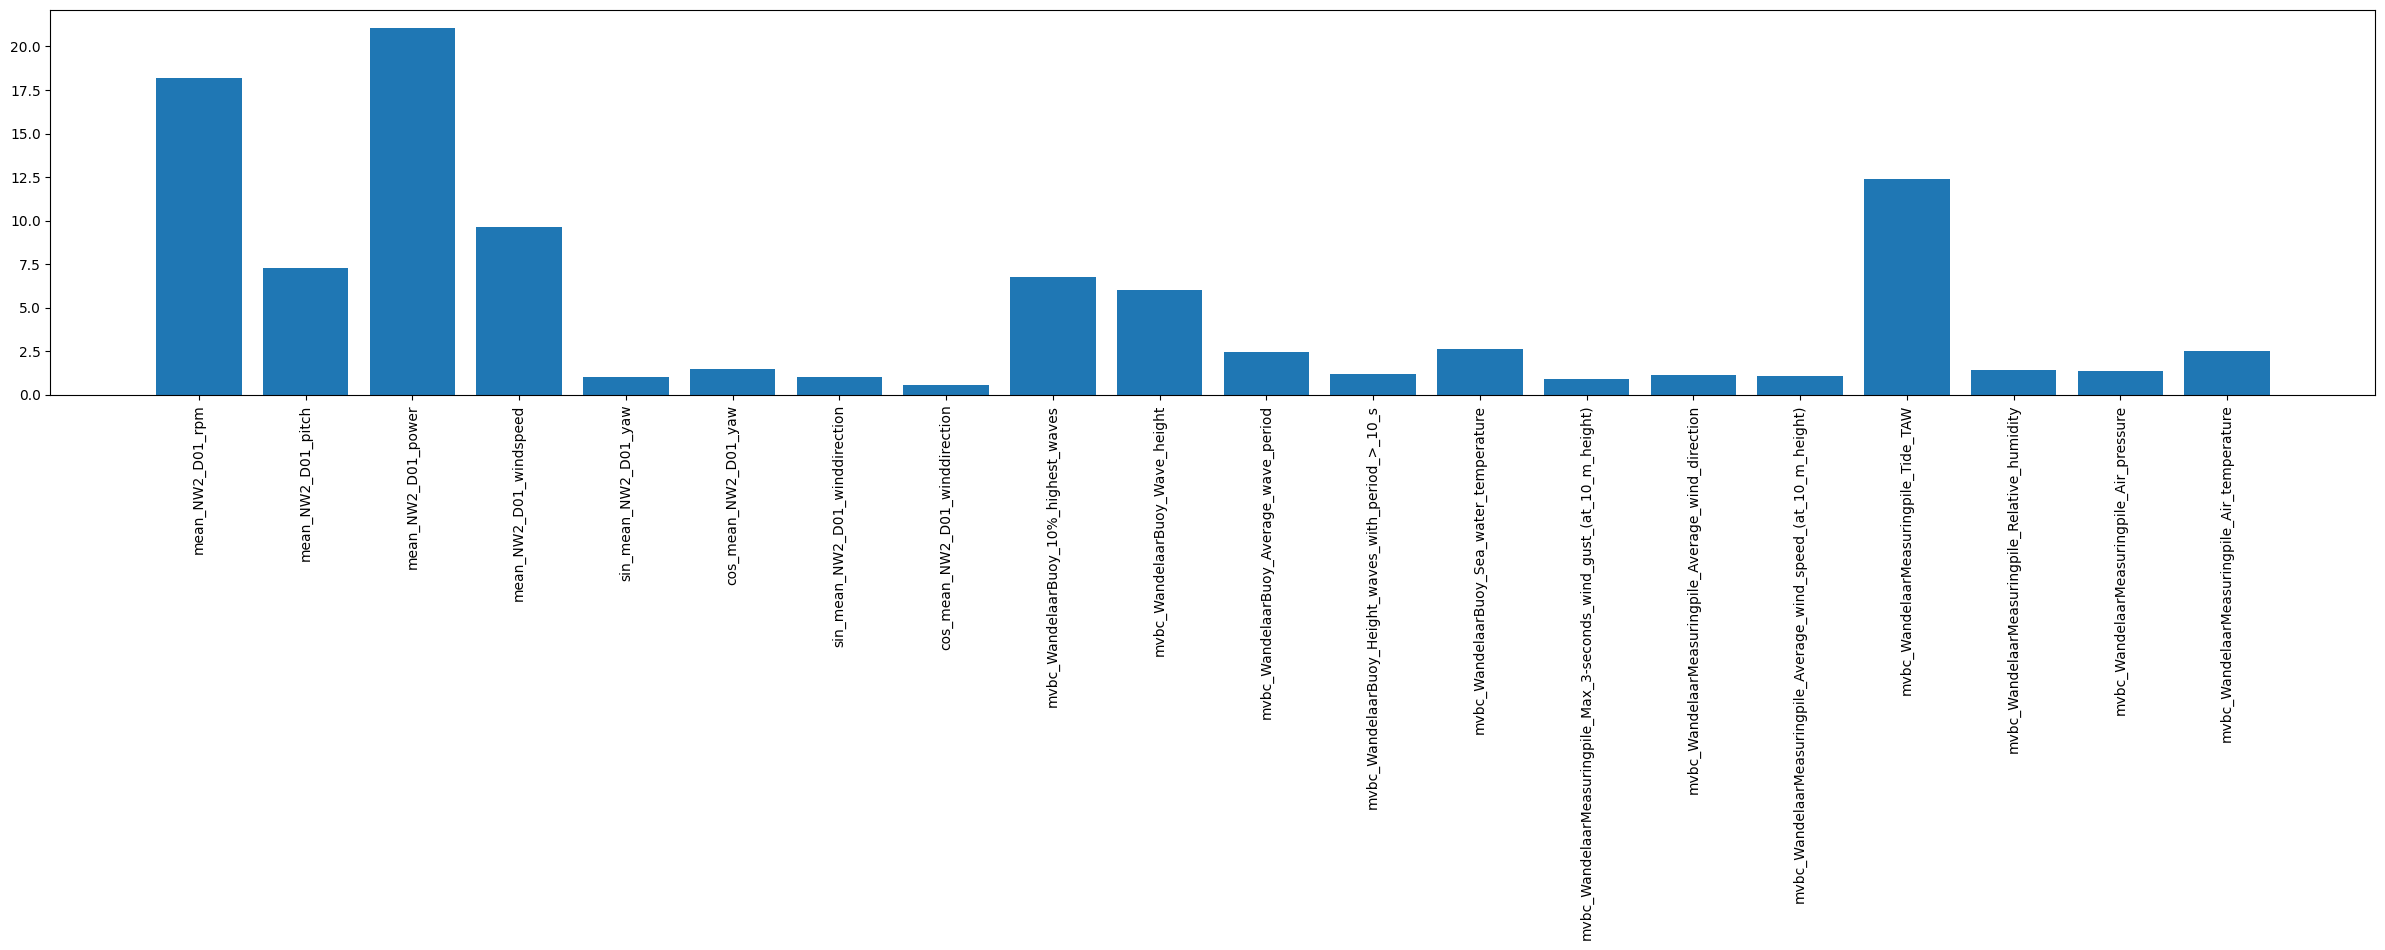

In [562]:
print(regr_model.feature_importances_)
print(regr_model.feature_names_)
plt.figure(figsize=(30,5))
plt.bar(regr_model.feature_names_, regr_model.feature_importances_)
plt.xticks(rotation=90)

In [563]:
ax2.scatter(preds_df.index, preds_df['data uncertainty'], label='data uncertainty', s=1, color='tab:orange')
